Tests CUDA support for FramesProcessor and AudioProcessor.

In [ ]:
import os
import time

import cv2
import torch
import numpy as np
import face_alignment
import matplotlib.pyplot as plt

import cheapfake.contrib.video_processor as video_processor

%matplotlib notebook

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print(torch.cuda.device_count())
else:
    print("CUDA device is not available.")
    
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [28]:
def _extract_landmarks(model, frame):
    landmarks = model.get_landmarks_from_image(frame)
    
    return landmarks

In [29]:
def extract_landmarks(frame, device="cpu", detector="sfd"):
    if device is "cuda":
        frame = torch.from_numpy(frame).cuda()
    
    model = face_alignment.FaceAlignment(
        face_alignment.LandmarksType._2D, device=device, face_detector=detector
    )
    landmarks = _extract_landmarks(model=model, frame=frame)
        
    return landmarks

In [30]:
def _batch_extract_landmarks(model, frames):
    batch_landmarks = model.get_landmarks_from_batch(frames)
    
    return batch_landmarks

In [31]:
def batch_extract_landmarks(frames, device="cpu", detector="sfd"):
    batch = np.stack(frames)
    if device is "cuda":
        batch = torch.from_numpy(batch).cuda()
    else:
        batch = torch.from_numpy(batch)
        
    model = face_alignment.FaceAlignment(
        face_alignment.LandmarksType._2D, device=device, face_detector=detector
    )
    batch_landmarks = _batch_extract_landmarks(model=model, frames=batch)
    
    return batch_landmarks

In [ ]:
video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)

frames = videofileprocessor.extract_all_frames(video_path=video_path, channel_first=False)
frame = frames[0]
framesprocessor = video_processor.FramesProcessor(verbose=True)

start_time = time.time()
landmarks = extract_landmarks(frame, device="cuda")
end_time = time.time()
print("Entire operation took {} seconds.".format(end_time - start_time))

In [ ]:
# This doesn't work because it's too big!
video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)

frames = videofileprocessor.extract_all_frames(
    video_path=video_path, channel_first=True, return_rgb=True
)
frames_subset = frames[:75]
framesprocessor = video_processor.FramesProcessor(verbose=True)

start_time = time.time()
batch_landmarks = batch_extract_landmarks(frames_subset, device="cpu")
end_time = time.time()
print("Entire operation took {} seconds.".format(end_time - start_time))

#### S3FD Resizing Experiment

In [ ]:
# Single image.
video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)

frames = videofileprocessor.extract_all_frames(video_path=video_path, channel_first=False, return_rgb=True)
frame = frames[0]

new_height = int(frame.shape[0] / 4)
new_width = int(frame.shape[1] / 4)
frame_resized = cv2.resize(frame, dsize=(new_width, new_height) , interpolation=cv2.INTER_LANCZOS4)
#dh, dw = frame.shape[0] / 640.0, frame.shape[1] / 640.0

start_time = time.time()
landmarks = extract_landmarks(frame_resized, device="cuda")
end_time = time.time()
print("Prediction with the resized image took {} seconds.".format(end_time - start_time))
landmarks[:,0] *= 4
landmarks[:,1] *= 4

start_time = time.time()
ground_truth = extract_landmarks(frame, device="cuda")
end_time = time.time()
print("Prediction with the original image took {} seconds.".format(end_time - start_time))

fig = plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(frame)
for landmark in ground_truth:
    plt.scatter(landmark[0], landmark[1], 1, c="b")

plt.subplot(1, 2, 2)
plt.imshow(frame)
for landmark in landmarks:
    plt.scatter(landmark[0], landmark[1], 1, c ="b")
    
diff = np.linalg.norm(landmarks - ground_truth)
print("The pixel difference between the ground truth and predicted is {}.".format(diff))

In [ ]:
# Let's try batch prediction with the 1/2 reduction!

video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)
frames = videofileprocessor.extract_all_frames(video_path=video_path, channel_first=False, return_rgb=True)
frames_subset = frames[:30]
scale_factor = 2
new_height = int(frames_subset[0].shape[0] / scale_factor)
new_width = int(frames_subset[0].shape[1] / scale_factor)
frames_resized = np.asarray(
    [
        cv2.resize(frame, dsize=(new_width, new_height), interpolation=cv2.INTER_LANCZOS4) 
        for frame in frames_subset
    ]
)
frames_resized = np.einsum("ijkl->iljk", frames_resized)

start_time = time.time()
batch_landmarks = batch_extract_landmarks(frames_resized, device="cuda")
end_time = time.time()
print("Entire operation took {} seconds.".format(end_time - start_time))

In [68]:
# Let's try batch prediction with the 1/4 reduction!

video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)
frames = videofileprocessor.extract_all_frames(video_path=video_path, channel_first=False, return_rgb=True)
frames_subset = frames[:75]
scale_factor = 4
new_height = int(frames_subset[0].shape[0] / scale_factor)
new_width = int(frames_subset[0].shape[1] / scale_factor)
frames_resized = np.asarray(
    [
        cv2.resize(frame, dsize=(new_width, new_height), interpolation=cv2.INTER_LANCZOS4) 
        for frame in frames_subset
    ]
)
frames_resized = np.einsum("ijkl->iljk", frames_resized)

start_time = time.time()
batch_landmarks = batch_extract_landmarks(frames_resized, device="cuda")
end_time = time.time()
print("Entire operation took {} seconds.".format(end_time - start_time))

Entire operation took 30.394304037094116 seconds.


In [73]:
# So 1/4 reduction works. Now let's see how they compare to a few images.
frames_testset = frames[:3]
frames_testset = np.einsum("ijkl->iljk", frames_testset)
frames_resized_testset = frames_resized[:3]

landmarks_test = np.asarray(batch_landmarks[:3])
landmarks_test = np.squeeze(landmarks_test, axis=1)
landmarks_test[:,:,0] *= 4
landmarks_test[:,:,1] *= 4
#print(landmarks_test)
landmarks_ground_truth_batch = np.asarray(batch_extract_landmarks(frames_testset, device="cuda"))
landmarks_ground_truth_batch = np.squeeze(landmarks_ground_truth_batch, axis=1)


frames_testset = np.einsum("ijkl->iklj", frames_testset)
frames_resized_testset = np.einsum("ijkl->iklj", frames_resized_testset)

<IPython.core.display.Javascript object>


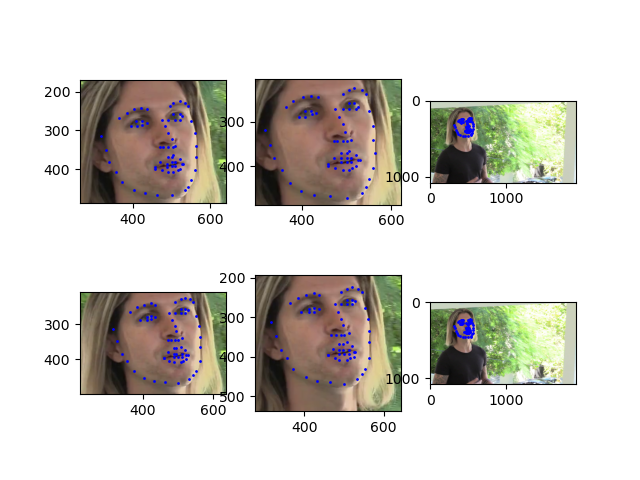

In [74]:
fig = plt.figure()

plt.subplot(2, 3, 1)
plt.imshow(frames_testset[0])
for landmark in landmarks_ground_truth_batch[0]:
    plt.scatter(landmark[0], landmark[1], 1, c="b")

plt.subplot(2, 3, 2)
plt.imshow(frames_testset[1])
for landmark in landmarks_ground_truth_batch[1]:
    plt.scatter(landmark[0], landmark[1], 1, c="b")

plt.subplot(2, 3, 3)
plt.imshow(frames_testset[2])
for landmark in landmarks_ground_truth_batch[2]:
    plt.scatter(landmark[0], landmark[1], 1, c="b")

plt.subplot(2, 3, 4)
plt.imshow(frames_testset[0])
for landmark in landmarks_test[0]:
    plt.scatter(landmark[0], landmark[1], 1, c="b")

plt.subplot(2, 3, 5)
plt.imshow(frames_testset[1])
for landmark in landmarks_test[1]:
    plt.scatter(landmark[0], landmark[1], 1, c="b")

plt.subplot(2, 3, 6)
plt.imshow(frames_testset[2])
for landmark in landmarks_test[2]:
    plt.scatter(landmark[0], landmark[1], 1, c="b")

### BlazeFace Stuff

In [ ]:
# Try with BlazeFace on a single image.
video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)

frames = videofileprocessor.extract_all_frames(
    video_path=video_path, channel_first=False, return_rgb=True
)
frames_subset = frames[0]
framesprocessor = video_processor.FramesProcessor(verbose=True)

start_time = time.time()
landmarks = extract_landmarks(frames_subset, device="cuda", detector="blazeface")
end_time = time.time()
print("Entire operation took {} seconds.".format(end_time - start_time))

In [ ]:
# Try with BlazeFace on a batch.
video_path = "/home/shu/shu/Datasets/DFDC_small_subset/aagfhgtpmv/video/aagfhgtpmv.mp4"
videofileprocessor = video_processor.VideoFileProcessor(verbose=True)

frames = videofileprocessor.extract_all_frames(
    video_path=video_path, channel_first=True, return_rgb=True
)
frames_subset = frames[:10]
framesprocessor = video_processor.FramesProcessor(verbose=True)

start_time = time.time()
batch_landmarks = batch_extract_landmarks(frames_subset, device="cpu", detector="blazeface")
end_time = time.time()
print("Entire operation took {} seconds.".format(end_time - start_time))